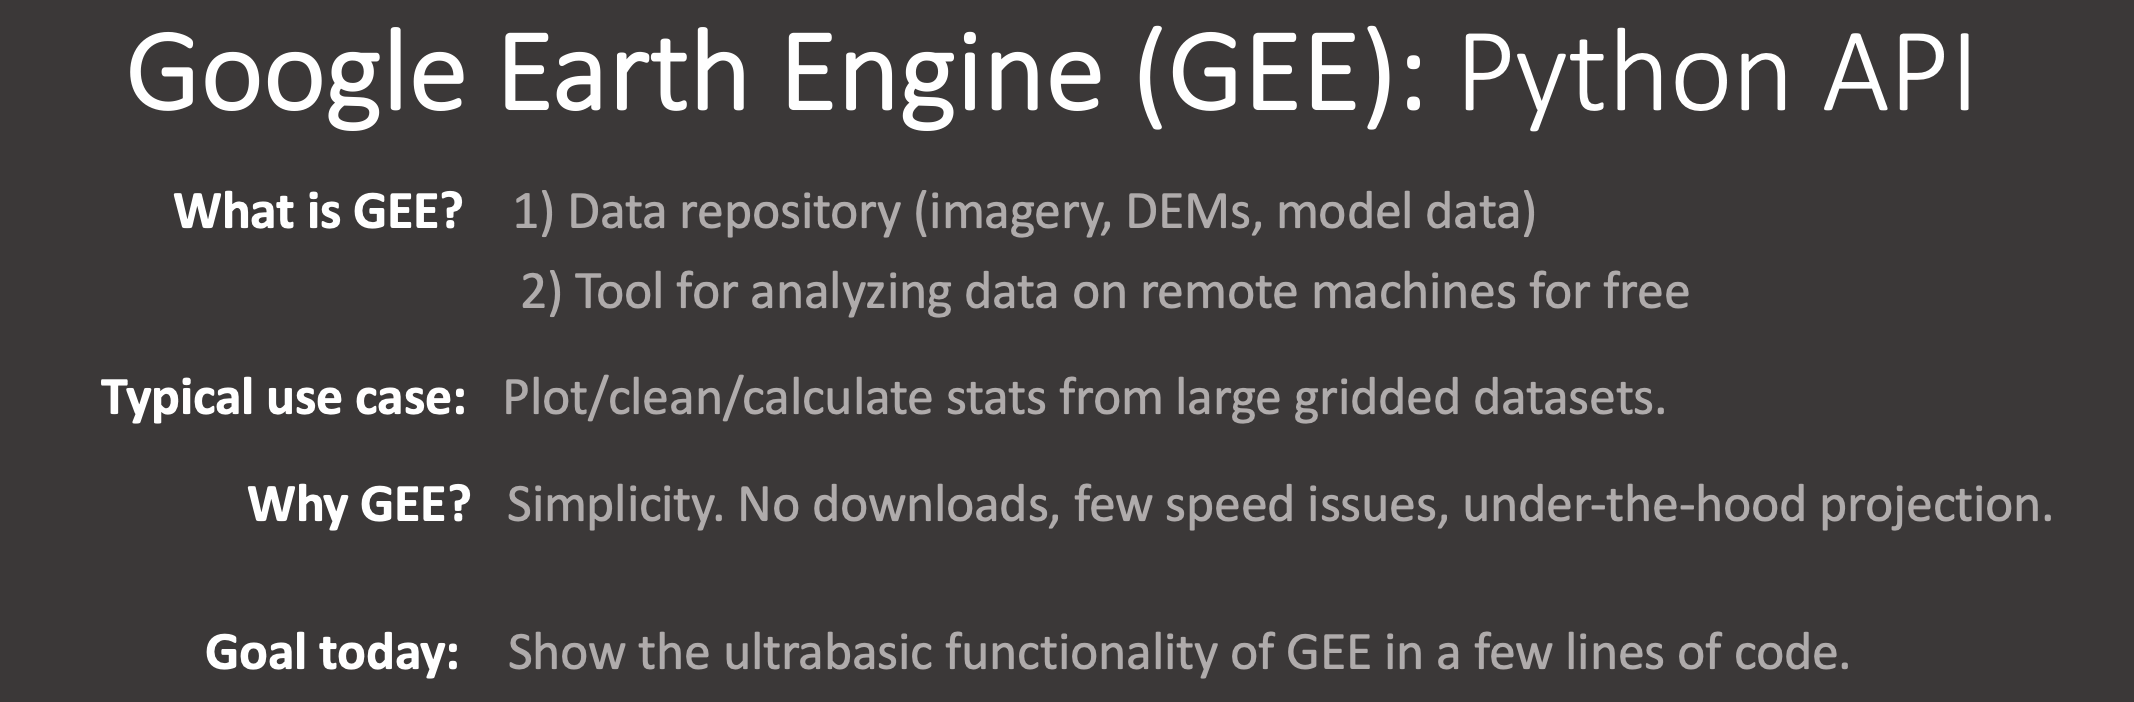

# First steps with GEE:

*   Data catalog: https://developers.google.com/earth-engine/datasets/
*   Get an account: https://earthengine.google.com/new_signup/
*   Get the Python API: https://developers.google.com/earth-engine/guides/python_install




# Example Part 1: Create a cloudless LANDSAT composite

In [12]:
#@title Import Folium, Initialize GEE

#[folium] interactive plotting 
import folium

#[ee] Google Earth Engine API 
import ee
ee.Authenticate()
ee.Initialize()

To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://accounts.google.com/o/oauth2/auth?client_id=517222506229-vsmmajv00ul0bs7p89v5m89qs8eb9359.apps.googleusercontent.com&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fearthengine+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdevstorage.full_control&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&response_type=code&code_challenge=pa50KtSnpwyv8d2f3LQ5cUO0FK80GjKFiVMh2lle5u0&code_challenge_method=S256

The authorization workflow will generate a code, which you should paste in the box below. 
Enter verification code: 4/1AX4XfWjbvnpqFhsfYQ26dVctS5t4GGZaFkvTFvzvo-Gu5VXJ4pisenaLMdU

Successfully saved authorization token.


In [13]:
#@title Define functions for plotting: "Mapdisplay", "add_ee_layer"

#Mapdisplay: Display GEE objects using folium.
def Mapdisplay(center, dicc, Tiles="OpensTreetMap",zoom_start=10):
    '''
    :param center: Center of the map (Latitude and Longitude).
    :param dicc: Earth Engine Geometries or Tiles dictionary
    :param Tiles: Mapbox Bright,Mapbox Control Room,Stamen Terrain,Stamen Toner,stamenwatercolor,cartodbpositron.
    :zoom_start: Initial zoom level for the map.
    :return: A folium.Map object.
    '''
    mapViz = folium.Map(location=center,tiles=Tiles, zoom_start=zoom_start)
    for k,v in dicc.items():
      if ee.image.Image in [type(x) for x in v.values()]:
        folium.TileLayer(
            tiles = v["tile_fetcher"].url_format,
            attr  = 'Google Earth Engine',
            overlay =True,
            name  = k
          ).add_to(mapViz)
      else:
        folium.GeoJson(
        data = v,
        name = k
          ).add_to(mapViz)
    mapViz.add_child(folium.LayerControl())
    return mapViz

# Define a method for displaying Earth Engine image tiles to folium map.
def add_ee_layer(self, ee_image_object, vis_params, name):
  map_id_dict = ee.Image(ee_image_object).getMapId(vis_params)
  folium.raster_layers.TileLayer(
    tiles = map_id_dict['tile_fetcher'].url_format,
    attr = "Map Data © Google Earth Engine",
    name = name,
    overlay = True,
    control = True
  ).add_to(self)

# Add Earth Engine drawing method to folium.
folium.Map.add_ee_layer = add_ee_layer

In [3]:
#@title Define a function for masking clouds using the L8SR bitmask: "maskL8sr"
def maskL8sr(image):
  cloudShadowBitMask = 1<<3
  cloudBitMask = 1<<5
  qa = image.select('pixel_qa')
  mask = qa.bitwiseAnd(cloudShadowBitMask).eq(0).And(qa.bitwiseAnd(cloudBitMask).eq(0))
  return image.updateMask(mask)

### 1a. Filter through an "ImageCollection" to create an "Image"
*   Filter LANDSAT 8 image collection by place, time
*   Mask pixels tagged as 'cloud' or 'cloud shadow' via bitmask
*   Reduce repeated observations by taking the median value

In [14]:
#Define a region of interest
roi = ee.Geometry.Rectangle([85, 8, 115, 25]);       

#Generate a Landsat 8 surface reflectance image object
my_image = ee.ImageCollection('LANDSAT/LC08/C01/T1_SR')\
  .filterBounds(roi)\
  .filterDate('2020-01-01', '2020-12-31').map(maskL8sr)\
  .reduce(ee.Reducer.median())

#Clip imagery to roi
my_image = my_image.clip(roi) 

#Check that image bands are as expected
band_names = my_image.bandNames()
print('Band names:', band_names.getInfo())

Band names: ['B1_median', 'B2_median', 'B3_median', 'B4_median', 'B5_median', 'B6_median', 'B7_median', 'B10_median', 'B11_median', 'sr_aerosol_median', 'pixel_qa_median', 'radsat_qa_median']


### 1b. Plot the ee.image using folium

In [15]:
#Create a folium map object
my_map = folium.Map(location=[17.5, 100], zoom_start=5, control_scale=True, height=500)

#Create a visualization using bands
RGB_viz={'bands':['B4_median','B3_median','B2_median'], 'min': 0, 'max': 5000, 'gamma': 1.4}
RNB_viz={'bands':['B4_median','B5_median','B2_median'], 'min': 0, 'max': 5000, 'gamma': 1.4}
NRB_viz={'bands':['B5_median','B4_median','B2_median'], 'min': 0, 'max': 5000, 'gamma': 1.4}

# Add the LANDSAT 8 composite created in 1a to the map object.
my_map.add_ee_layer(my_image, RNB_viz, '2020')

# Add a layer control panel to the map.
my_map.add_child(folium.LayerControl())

# Display the map.
display(my_map)

### 1c. Calculate statistics over your ROI

In [16]:
sum = my_image.reduceRegion(ee.Reducer.sum(), roi, 20000)
sum.getInfo()

{'B10_median': 32651280.80196078,
 'B11_median': 32387946.013725467,
 'B1_median': 3874351.911764709,
 'B2_median': 4573534.852941177,
 'B3_median': 6651073.064705876,
 'B4_median': 5879691.399999999,
 'B5_median': 21426356.619607866,
 'B6_median': 15225362.849019608,
 'B7_median': 8885999.54509804,
 'pixel_qa_median': 3564012.3098039157,
 'radsat_qa_median': 0,
 'sr_aerosol_median': 1633602.1882352948}

### 1d. Export ee.image to Google Drive storage as a GeoTiff


In [17]:
export = ee.batch.Export.image.toDrive(
        image = my_image,             
        region = roi.bounds().getInfo()['coordinates'],
        dimensions = 1440,  #Set the resolution of the image
        description = 'GEE_Export_Example')
export.start()